In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde, gamma, lognorm, entropy
import pandas as pd

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, NODE_model
from utils import train_jp, eval_Cauchy_vmap, merge_weights_iso
from utils_diffusion import *

from scipy.stats import energy_distance as dist_fn

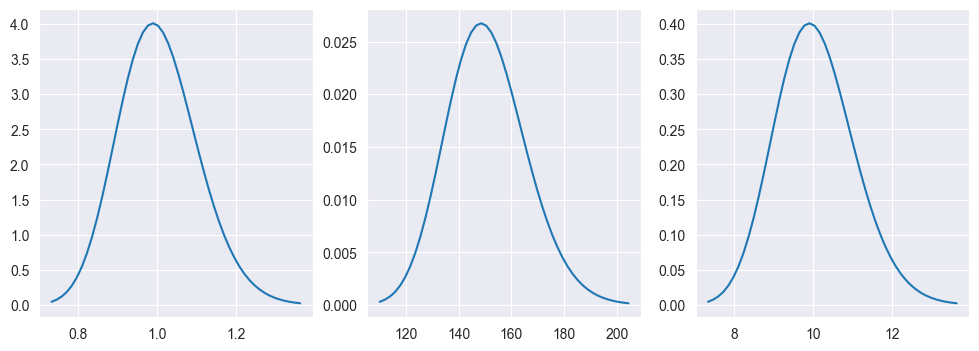

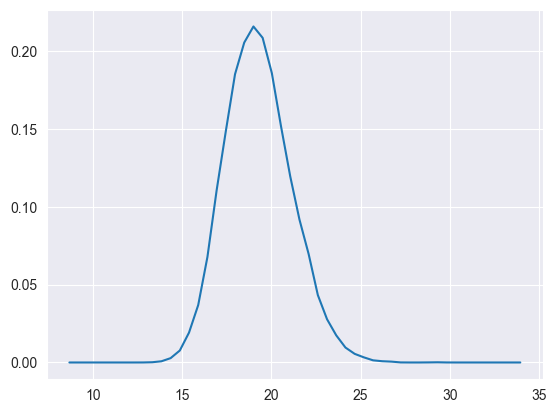

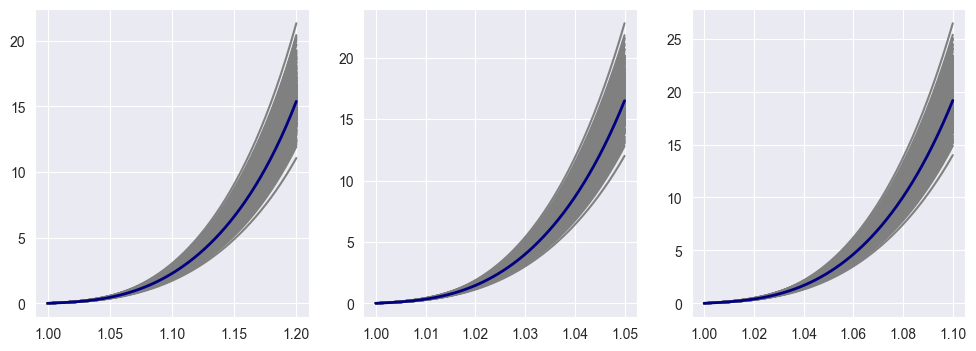

In [2]:
# Generate training data from May-Newmann model
MN_params  = [1.0,         150,         10] # baseline params
J = 10000 # J different samples 
fig, ax = plt.subplots(1,3,figsize=(12,4))
MN_params_s = np.zeros((J,len(MN_params)))
theta = 1.0
for j in range(len(MN_params)):
    p = MN_params[j]
    s = 0.1
    scale = p
    x = np.linspace(lognorm.ppf(0.001, s, scale=scale), 
                    lognorm.ppf(0.999, s, scale=scale))
    y = lognorm.pdf(x, s, scale=scale)
    ax[j].plot(x,y)
    for i in range(J):
        MN_params_s[i,j] = lognorm.rvs(s, scale=p)

# Given thse parameters, generate bunch of curves for different tests
# and plot to see: 3 different biaxial deformations going from strip biax, to off, to equi-biaxial 
lam_ls = np.linspace(1,1.2,50)
lam_vec = np.zeros((3*50,2))
for i in range(3):
    alpha = i/4
    lam_vec[i*50:(i+1)*50,0] = 1+alpha*(lam_ls-1)
    lam_vec[i*50:(i+1)*50,1] = 1+(1-alpha)*(lam_ls-1)


# Estimate the kde of sigma_x at lmbx=1.1 for equibiaxial loading
sigma_gt_s = []
header = 'x'
for j in range(J):
    sigma_gt_si = mn_sigma(lam_vec, MN_params_s[j])
    sigma_gt_s.append(sigma_gt_si)

data_stat = np.array(sigma_gt_s)[:,0,-1] #the last sigma_x for each sample
data_kde = gaussian_kde(data_stat)
xmin = np.min(data_stat)
xmax = np.max(data_stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
qk = data_kde(x)

fig, ax = plt.subplots()
ax.plot(x,qk)

# Generate fewer samples for training the diffusion model.
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
J = 500
# sigma_gt_s = []
header = 'x'
sigma_gt_s = sigma_gt_s[:J]
for j in range(J):
    sigma_gt_si = sigma_gt_s[j]
    axs[0].plot(lam_vec[:50,1],         sigma_gt_si[0][:50]       ,color='grey')
    axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_si[0][50:2*50]   ,color='grey')
    axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_si[0][2*50:3*50] ,color='grey')

# mean response
sigma_gt_m = mn_sigma(lam_vec, MN_params)
axs[0].plot(lam_vec[:50,1],         sigma_gt_m[0][:50]      ,color='navy',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_m[0][50:2*50]  ,color='navy',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_m[0][2*50:3*50],color='navy',linewidth=2)


with open('params/data.npy', 'wb') as f:
    pickle.dump([lam_vec, sigma_gt_s, sigma_gt_m, data_stat], f)

In [2]:
with open('params/data.npy', 'rb') as f:
    lam_vec, sigma_gt_s, sigma_gt_m, data_stat = pickle.load(f)
J = len(sigma_gt_s)

# Restructure the stress-stretch data a bit
lamx_all,   lamy_all    = np.array([lam_vec]*J).reshape([-1,2]).T     # Repeat the same lmx & lmy values J times
sigmax_all, sigmay_all  = np.array(sigma_gt_s).transpose([1,0,2]).reshape([2,-1])
lamb_sigma = np.vstack([lamx_all,lamy_all,sigmax_all,sigmay_all]).transpose()

## just the mean response
sigmax_r = lamb_sigma[:,2].reshape((J,150))
sigma_x_m = np.mean(sigmax_r,axis=0)
sigmay_r = lamb_sigma[:,3].reshape((J,150))
sigma_y_m = np.mean(sigmay_r,axis=0)
lamb_sigma_m = np.vstack([lam_vec[:,0],lam_vec[:,1],sigma_x_m,sigma_y_m]).transpose()

In [ ]:
# Run this part on the cluster because it takes too long.

# # Define the loss function for when training all params
# @jit
# def loss_sig_all(params, lamb_sigma):
#     model   = NODE_model(params)
#     lambx   = lamb_sigma[:,0]
#     lamby   = lamb_sigma[:,1]
#     sigmax  = lamb_sigma[:,2]
#     sigmay  = lamb_sigma[:,3]
#     sigx,sigy = eval_Cauchy_vmap(lambx,lamby, model)
#     return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

# key = random.PRNGKey(0)
# for n_last_layer in range(1,11):
#     common_layers = [1, n_last_layer, n_last_layer]
#     sample_layers = [n_last_layer, 1]
    
#     cparams = init_params(common_layers, sample_layers, key)
#     opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
#     opt_state = opt_init(cparams)


#     # Train
#     print('Last layer size: ', n_last_layer)
#     print('Training with mean response...')
#     cparams, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma_m, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=200000)
#     print('Finished training with the mean response. Training loss = {}'.format(train_loss[-1]))

#     print('Training individuals...')
#     NODE_weights, Psi1_bias, Psi2_bias = cparams
#     params_I1, params_I2 = NODE_weights
#     params_I1c,params_I1s = params_I1
#     params_I2c,params_I2s = params_I2
#     def loss_sample(sample_params, X): #This keeps the common params constant and varies sample_params
#         params = merge_weights_iso(cparams, sample_params)
#         return loss_sig_all(params, X)

#     mean_sample_params = (params_I1s, params_I2s, Psi1_bias, Psi2_bias)
    
#     sparams = []
#     Train_loss = []
#     for j in range(J):
#         sigx = sigma_gt_s[j][0]
#         sigy = sigma_gt_s[j][1]
#         lamb_sigma_j = np.vstack([lam_vec[:,0],lam_vec[:,1],sigx,sigy]).transpose()
#         opt_init, opt_update, get_params = optimizers.adam(1e-3)
#         opt_state = opt_init(mean_sample_params)

#         sample_params, train_loss, val_loss = train_jp(loss_sample, lamb_sigma_j, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=20000)
#         sparams.append(sample_params)
#         Train_loss.append(train_loss[-1])
#         print('Indv. {}, training loss = {}'.format(j, train_loss[-1]))

#     w_diffusion = np.array([ravel_pytree(sample_params)[0] for sample_params in sparams])
#     unravel_params = ravel_pytree(sparams[0])[1]
#     mu_x  = jnp.mean(w_diffusion,0)
#     std_x = jnp.std (w_diffusion,0)
#     w_diffusion_scaled = (w_diffusion-mu_x)/std_x

    
    
#     # Diffusion
#     print('Training the diffusion model...')
#     batch_size = 16
#     #some dummy input data. Flax is able to infer all the dimensions of the weights
#     #if we supply if with the kind of input data it has to expect
#     aux = jnp.zeros((w_diffusion_scaled.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled.shape[1]))
#     time = jnp.ones((batch_size, 1))
#     #initialize the model weights
#     score_model = ApproximateScore() # from diffusion_utils
#     diff_params = score_model.init(rng, aux, time) # from diffusion_utils
#     #Initialize the optimizer
#     optimizer = optax.adam(5.e-4)
#     opt_state = optimizer.init(diff_params)
#     N_epochs = 5000
#     train_size = w_diffusion.shape[0]
#     batch_size = 20
#     batch_size = min(train_size, batch_size)
#     steps_per_epoch = train_size // batch_size

#     diff_params = train_diffusion(w_diffusion_scaled, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, diff_params, optimizer, opt_state)

#     with open('params/sens_synth_n{}.npy'.format(n_last_layer), 'wb') as f:
#         pickle.dump([cparams, sparams, Train_loss, diff_params], f)

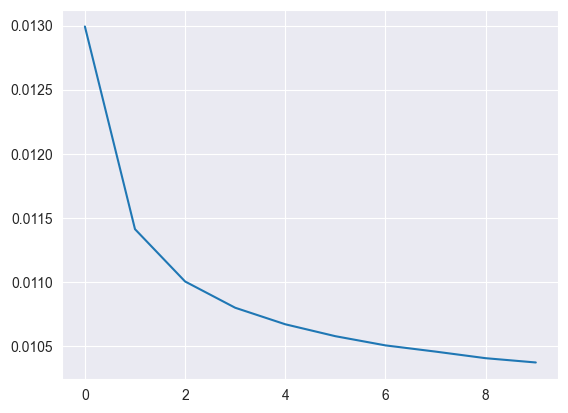

In [46]:
errors = []
for n_last_layer in range(1,11):
    with open('params/sens_synth_n{}.npy'.format(n_last_layer), 'rb') as f:
        cparams, sparams, Train_loss, diff_params = pickle.load(f)
    errors_j = []
    for j in range(J):
        # Construct the model and evaluate stresses for each individual after training
        params = merge_weights_iso(cparams, sparams[j])
        mymodel = NODE_model(params)

        sgm = eval_Cauchy_vmap(lam_vec[100:,0],lam_vec[100:,0], mymodel)
        sgmx_pr, sgmy_pr = sgm
        sgmx_gt, sgmy_gt = sigma_gt_s[j]
        sgmx_gt, sgmy_gt = sgmx_gt[100:], sgmy_gt[100:]
        err = jnp.mean(0.5*(jnp.abs(sgmx_pr-sgmx_gt) + jnp.abs(sgmy_pr-sgmy_gt)))/np.max(np.stack([sgmx_gt, sgmy_gt]))
        errors_j.append(err)
    errors.append(np.mean(errors_j))
    
plt.plot(errors)
np.savetxt('tikz/fig_w_sensitivity_data/error.csv', np.vstack([np.arange(1,11)*2, errors]).T)

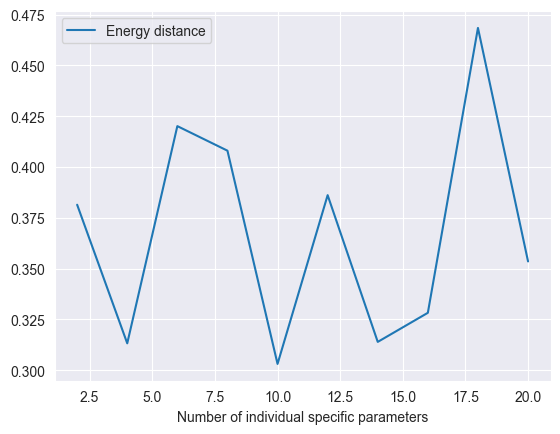

In [47]:
dist = []
loss = []
for n_last_layer in range(1,11):
    with open('params/sens_synth_n{}.npy'.format(n_last_layer), 'rb') as f:
        cparams, sparams, Train_loss, diff_params = pickle.load(f)

    w_diffusion = np.array([ravel_pytree(sample_params)[0] for sample_params in sparams])
    unravel_params = ravel_pytree(sparams[0])[1]
    mu_x  = jnp.mean(w_diffusion,0)
    std_x = jnp.std (w_diffusion,0)
    w_diffusion_scaled = (w_diffusion-mu_x)/std_x
    score_model = ApproximateScore()

    rng, step_rng = random.split(rng)
    trained_score = lambda x, t: score_model.apply(diff_params, x, t)
    samples = reverse_sde(step_rng, w_diffusion.shape[1], 1000, drift, dispersion, trained_score)

    # Make stress predictions and compare
    stat = []
    Model_sgm = []
    for l in samples:
        l_unscaled = l*std_x+mu_x 
        sample_params = unravel_params(l_unscaled)

        params = merge_weights_iso(cparams, sample_params)

        mymodel = NODE_model(params)
        model_sgm = eval_Cauchy_vmap(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel)
        Model_sgm.append(model_sgm)
        sigx, sigy = model_sgm
        stat.append(sigx[-1])
    dist.append(dist_fn(stat,data_stat))
    loss.append(np.mean(Train_loss))

fig, ax = plt.subplots()
ax.plot(np.arange(1,11)*2,dist, label='Energy distance')
ax.set(xlabel='Number of individual specific parameters')
ax.legend()
fig.savefig('figs/fig_sensitivity_synthetic.jpg')

np.savetxt('tikz/fig_w_sensitivity_data/energy_dist.csv', np.vstack([np.arange(1,11)*2, dist]).T)